In [1]:
!pip install transformers sentencepiece

In [2]:
import pandas as pd
import random
import numpy as np
import re
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch import nn
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
from tqdm.notebook import tqdm
from gensim.models import Word2Vec

2025-12-24 16:57:24.138433: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766595444.368994      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766595444.435851      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
data_set1 = pd.read_csv('/kaggle/input/data-c-devign-test1/data_C_Devign_test.csv')
data_set2 = pd.read_csv('/kaggle/input/data-c-linevul-test/data_C_LineVul_test.csv')
data_set3 = pd.read_csv('/kaggle/input/data-c-primevul-test/data_C_PrimeVul_test.csv')
data_set4 = pd.read_csv('/kaggle/input/data-c-ours-train/data_C_Ours_train.csv')
data_set5 = pd.read_csv('/kaggle/input/data-c-ours-test/data_C_Ours_test.csv')
data_set6 = pd.read_csv('/kaggle/input/megavul-only-vulnerable/megavul_only_vulnerable.csv')

In [5]:
data_set1 = data_set1.drop(columns=['Unnamed: 0', 'id', 'project', 'commit_id'])
data_set1 = data_set1.rename(columns={
    'func': 'code',
    'target': 'label'
})

data_set2 = data_set2.drop(columns=['Unnamed: 0', 'unique_id', '__index_level_0__'])
data_set2 = data_set2.rename(columns={
    'target': 'label'
})

data_set3 = data_set3.rename(columns={
    'target': 'label'
})

data_set4 = data_set4.drop(columns=['Unnamed: 0', 'cwe_id', 'repo', 'path', 'url', 'sha'])
data_set4 = data_set4.rename(columns={
    'target': 'label'
})

data_set5 = data_set5.drop(columns=['Unnamed: 0', 'cwe_id', 'repo', 'path', 'url', 'sha'])
data_set5 = data_set5.rename(columns={
    'target': 'label'
})

In [6]:
data_set = pd.concat([data_set1, data_set2, data_set3, data_set4, data_set5, data_set6], ignore_index=True)
data_set.dropna(subset=['code', 'label'], inplace=True)
data_set = data_set[data_set['code'].astype(str).str.strip().str.len() > 0]

In [7]:
data_set

,code,label
0,"int ff_get_wav_header(AVFormatContext *s, AVIO...",0
1,static int xen_9pfs_connect(struct XenDevice *...,1
2,static int subframe_count_exact(FlacEncodeCont...,1
3,static void ppc_spapr_init(QEMUMachineInitArgs...,0
4,static int mpeg1_decode_sequence(AVCodecContex...,0
...,...,...
103592,"int __kvm_set_memory_region(struct kvm *kvm,\n...",1
103593,static int kvm_iommu_unmap_memslots(struct kvm...,1
103594,int cap_bprm_set_creds(struct linux_binprm *bp...,1
103595,Navigator* LocalDOMWindow::navigator() const\n...,1


In [8]:
pd.set_option('display.max_colwidth', None)
from sklearn.model_selection import train_test_split
train_ratio = 0.8
val_test_ratio = 0.1

df_train, temp_data = train_test_split(data_set, train_size=train_ratio, random_state=42)
df_validation, df_test = train_test_split(temp_data, train_size=0.5, random_state=42)

print(f"Train: {len(df_train)} rows")
print(f"Validation: {len(df_validation)} rows")
print(f"Test: {len(df_test)} rows")

Train: 82877 rows
Validation: 10360 rows
Test: 10360 rows


In [9]:
from collections import Counter

def print_distribution(name, labels):
    counter = Counter(labels)
    total = sum(counter.values())
    
    print(f"\n{name} Distribution:")
    for label, count in counter.items():
        percentage = (count / total) * 100
        class_name = "Vulnerable" if label == 1 else "Non-Vulnerable"
        print(f"  {class_name}: {count} ({percentage:.2f}%)")

print_distribution("Whole Dataset", data_set["label"])

print_distribution("Train Set", df_train["label"])
print_distribution("Validation Set", df_validation["label"])
print_distribution("Test Set", df_test["label"])


Whole Dataset Distribution:
  Non-Vulnerable: 64646 (62.40%)
  Vulnerable: 38951 (37.60%)

Train Set Distribution:
  Vulnerable: 31254 (37.71%)
  Non-Vulnerable: 51623 (62.29%)

Validation Set Distribution:
  Vulnerable: 3818 (36.85%)
  Non-Vulnerable: 6542 (63.15%)

Test Set Distribution:
  Non-Vulnerable: 6481 (62.56%)
  Vulnerable: 3879 (37.44%)


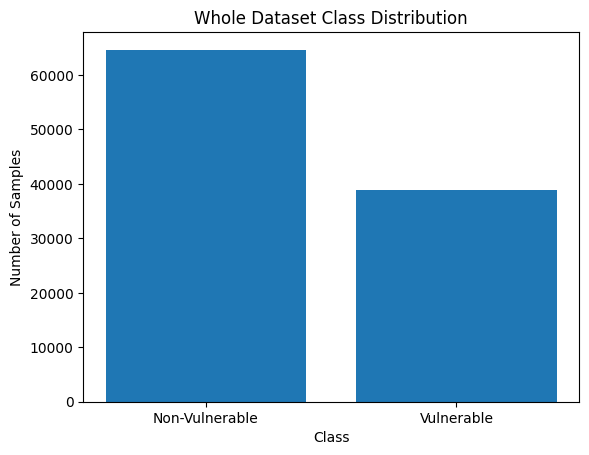

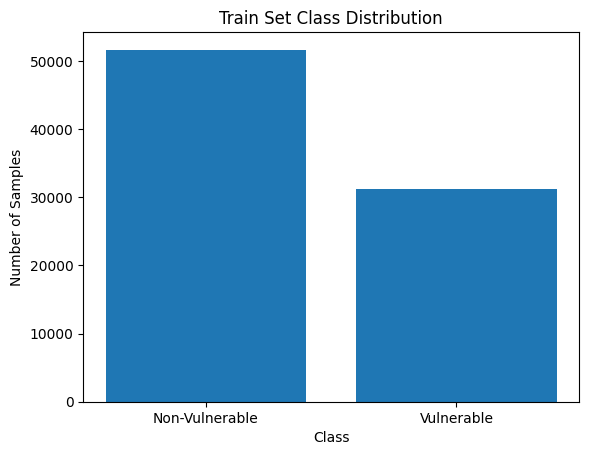

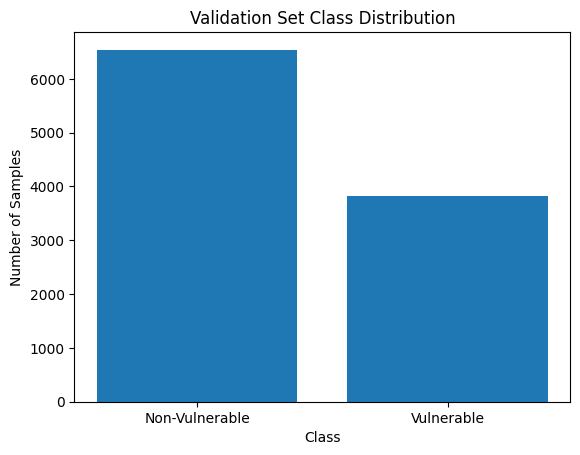

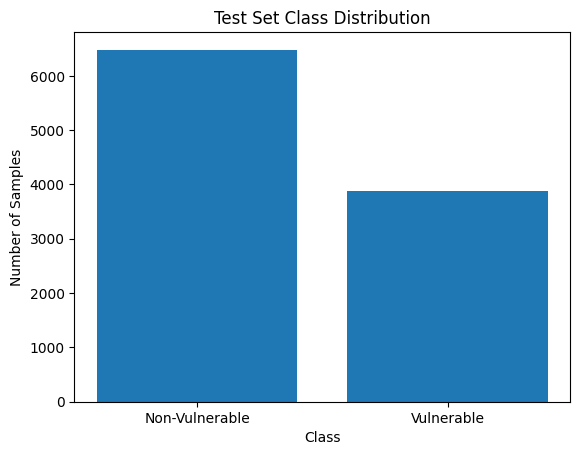

In [10]:
import matplotlib.pyplot as plt

def plot_distribution(title, labels):
    counter = Counter(labels)
    classes = ["Non-Vulnerable", "Vulnerable"]
    values = [counter.get(0, 0), counter.get(1, 0)]

    plt.figure()
    plt.bar(classes, values)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Number of Samples")
    plt.show()

plot_distribution("Whole Dataset Class Distribution", data_set["label"])
plot_distribution("Train Set Class Distribution", df_train["label"])
plot_distribution("Validation Set Class Distribution", df_validation["label"])
plot_distribution("Test Set Class Distribution", df_test["label"])

In [9]:
def remove_comments(code):
    code = re.sub(r'/\*.*?\*/', '', code, flags=re.DOTALL)
    code = re.sub(r'//.*', '', code)
    return code

def normalize_whitespace(code):
    code = code.replace('\t', ' ')
    code = code.replace('\n', ' ')
    code = " ".join(code.split())
    return code

def fix_encoding(code):
    code = code.encode('utf-8', errors='ignore').decode('utf-8')
    return code

def replace_literals(code):
    code = re.sub(r'"(\\.|[^"\\])*"', 'STRING_LITERAL', code, flags=re.DOTALL)
    code = re.sub(r"'(\\.|[^'\\])*'", 'CHAR_LITERAL', code)
    code = re.sub(r'\b\d+(\.\d+)?\b', 'NUMBER', code)
    return code

def strip_includes_and_macros(code):
    code = re.sub(r'^\s*#\s*include.*$', '', code, flags=re.MULTILINE)
    code = re.sub(r'^\s*#\s*define.*(?:\\\n.*)*', '', code, flags=re.MULTILINE)
    return code

def preprocess_code(code):
    code = remove_comments(code)
    code = strip_includes_and_macros(code)
    code = replace_literals(code)
    code = normalize_whitespace(code)
    code = fix_encoding(code)
    return code

In [10]:
%pip install Preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for nltk: filename=nltk-3.2.4-py3-none-any.whl size=1367711 sha256=e4be41b48322825f5f87cf244098d2b8f42a8c05a06c43a99870fb854a509399
  Stored in directory: /root/.cache/pip/wheels/49/53/b9/131418594f8097bae841406596db5cfdedbc725ccb40d60d76
Successfully built nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.9.2
    Uninstalling nltk-3.9.2:
      Successfully uninstalled nltk-3.9.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
textblob 0.19.0 requires nltk>=3.9, but you have nltk 3.2.4 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [11]:
from transformers import RobertaTokenizerFast

tokenizer = RobertaTokenizerFast.from_pretrained("microsoft/codebert-base")
MAX_LEN = 512

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

In [12]:
df_train["code"] = df_train["code"].apply(preprocess_code)
df_validation["code"] = df_validation["code"].apply(preprocess_code)
df_test["code"] = df_test["code"].apply(preprocess_code)

In [13]:
def tokenize_dataframe(df):
    encoded = tokenizer(
        df["code"].tolist(),
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    )
    return encoded["input_ids"], encoded["attention_mask"]

train_input_ids, train_attention = tokenize_dataframe(df_train)
val_input_ids,   val_attention   = tokenize_dataframe(df_validation)
test_input_ids,  test_attention  = tokenize_dataframe(df_test)

train_labels = torch.tensor(df_train["label"].values, dtype=torch.float)
val_labels   = torch.tensor(df_validation["label"].values, dtype=torch.float)
test_labels  = torch.tensor(df_test["label"].values, dtype=torch.float)

In [14]:
train_dataset = TensorDataset(train_input_ids, train_attention, train_labels)
val_dataset   = TensorDataset(val_input_ids, val_attention, val_labels)
test_dataset  = TensorDataset(test_input_ids, test_attention, test_labels)

BATCH_SIZE = 16

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader   = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataloader  = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [15]:
from transformers import RobertaModel

import torch
import torch.nn as nn
from transformers import RobertaModel


class CodeBERTClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.codebert = RobertaModel.from_pretrained("microsoft/codebert-base")

        self.norm = nn.LayerNorm(768)

        self.classifier = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )

    def mean_pooling(self, hidden_states, attention_mask):
        mask = attention_mask.unsqueeze(-1).float()
        summed = torch.sum(hidden_states * mask, dim=1)
        counts = torch.clamp(mask.sum(dim=1), min=1e-9)
        return summed / counts

    def forward(self, input_ids, attention_mask):
        outputs = self.codebert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        pooled = self.mean_pooling(outputs.last_hidden_state, attention_mask)
        pooled = self.norm(pooled)

        return self.classifier(pooled).squeeze(-1)

In [16]:
device = torch.device("cuda")

model = CodeBERTClassifier()

if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
    model = nn.DataParallel(model)

model = model.to(device)

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Using 2 GPUs


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [17]:
from collections import Counter
import torch

all_labels = []
for _, _, labels in train_dataloader:
    all_labels.extend(labels.cpu().numpy())

counts = Counter(all_labels)
neg = counts[0]
pos = counts[1]

print("Class counts:", counts)

pos_weight = torch.tensor([neg / pos], dtype=torch.float32).to(device)

print("pos_weight =", pos_weight)

Class counts: Counter({0.0: 51623, 1.0: 31254})
pos_weight = tensor([1.6517], device='cuda:0')


In [18]:
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(preds, labels, probs):
    preds = np.array(preds)
    labels = np.array(labels)

    acc  = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, zero_division=0)
    rec  = recall_score(labels, preds, zero_division=0)
    f1   = f1_score(labels, preds, zero_division=0)

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    }

In [20]:
def train(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    preds_list, labels_list, probs_list = [], [], []

    for input_ids, attention_mask, labels in tqdm(dataloader):
        input_ids, attention_mask, labels = (
            input_ids.to(device),
            attention_mask.to(device),
            labels.to(device)
        )

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        probs = torch.sigmoid(outputs).detach().cpu().numpy()
        preds = (probs >= 0.5).astype(int)

        preds_list.extend(preds)
        labels_list.extend(labels.cpu().numpy())
        probs_list.extend(probs)

    metrics = compute_metrics(preds_list, labels_list, probs_list)
    return total_loss / len(dataloader), metrics

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate(model, dataloader, criterion=None):
    model.eval()
    total_loss = 0
    preds_list, labels_list, probs_list = [], [], []

    with torch.no_grad():
        for input_ids, attention_mask, labels in dataloader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            logits = model(input_ids, attention_mask)
            probs = torch.sigmoid(logits)

            preds = (probs >= 0.5).int()

            preds_list.extend(preds.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())
            probs_list.extend(probs.cpu().numpy())

            if criterion is not None:
                loss = criterion(logits, labels)
                total_loss += loss.item()

    metrics = {
        "accuracy": accuracy_score(labels_list, preds_list),
        "precision": precision_score(labels_list, preds_list, zero_division=0),
        "recall": recall_score(labels_list, preds_list, zero_division=0),
        "f1": f1_score(labels_list, preds_list, zero_division=0)
    }

    avg_loss = total_loss / len(dataloader) if criterion else None
    return avg_loss, metrics

In [22]:
N_EPOCHS = 10
patience = 2
best_val_f1 = 0.0
patience_counter = 0

for epoch in range(N_EPOCHS):
    train_loss, train_metrics = train(model, train_dataloader, optimizer, criterion)
    val_loss, val_metrics = evaluate(model, val_dataloader, criterion)

    print(f"\nEpoch {epoch+1}/{N_EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Train F1:   {train_metrics['f1']:.4f}")
    print(f"Val Loss:   {val_loss:.4f}")
    print(f"Val F1:     {val_metrics['f1']:.4f}")

    if val_metrics["f1"] > best_val_f1:
        best_val_f1 = val_metrics["f1"]
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
        print("✔ Validation F1 improved. Model saved.")
    else:
        patience_counter += 1
        print(f"✖ No improvement. Patience {patience_counter}/{patience}")

    if patience_counter >= patience:
        print("\n🛑 Early stopping triggered.")
        break

  0%|          | 0/5180 [00:00<?, ?it/s]


Epoch 1/10
Train Loss: 0.6835
Train F1:   0.6610
Val Loss:   0.6078
Val F1:     0.6986
✔ Validation F1 improved. Model saved.


  0%|          | 0/5180 [00:00<?, ?it/s]


Epoch 2/10
Train Loss: 0.5434
Train F1:   0.7377
Val Loss:   0.5405
Val F1:     0.7290
✔ Validation F1 improved. Model saved.


  0%|          | 0/5180 [00:00<?, ?it/s]


Epoch 3/10
Train Loss: 0.4484
Train F1:   0.7846
Val Loss:   0.5505
Val F1:     0.7213
✖ No improvement. Patience 1/2


  0%|          | 0/5180 [00:00<?, ?it/s]


Epoch 4/10
Train Loss: 0.3731
Train F1:   0.8218
Val Loss:   0.5840
Val F1:     0.7401
✔ Validation F1 improved. Model saved.


  0%|          | 0/5180 [00:00<?, ?it/s]


Epoch 5/10
Train Loss: 0.3196
Train F1:   0.8463
Val Loss:   0.6987
Val F1:     0.7301
✖ No improvement. Patience 1/2


  0%|          | 0/5180 [00:00<?, ?it/s]


Epoch 6/10
Train Loss: 0.2836
Train F1:   0.8637
Val Loss:   0.6686
Val F1:     0.7413
✔ Validation F1 improved. Model saved.


  0%|          | 0/5180 [00:00<?, ?it/s]


Epoch 7/10
Train Loss: 0.2545
Train F1:   0.8793
Val Loss:   0.6596
Val F1:     0.7309
✖ No improvement. Patience 1/2


  0%|          | 0/5180 [00:00<?, ?it/s]


Epoch 8/10
Train Loss: 0.2313
Train F1:   0.8903
Val Loss:   0.8701
Val F1:     0.7259
✖ No improvement. Patience 2/2

🛑 Early stopping triggered.


In [ ]:
def find_best_threshold(model, dataloader):
    model.eval()
    probs, labels = [], []

    with torch.no_grad():
        for input_ids, attention_mask, y in dataloader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            logits = model(input_ids, attention_mask)
            probs.extend(torch.sigmoid(logits).cpu().numpy())
            labels.extend(y.numpy())

    best_f1, best_t = 0, 0.5
    for t in np.arange(0.1, 0.9, 0.01):
        preds = (np.array(probs) >= t).astype(int)
        f1 = f1_score(labels, preds)
        if f1 > best_f1:
            best_f1, best_t = f1, t

    return best_t, best_f1

In [ ]:
best_t, best_f1 = find_best_threshold(model, val_dataloader)
print("Best threshold:", best_t)

In [23]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

print("✔ Best model loaded (based on Validation F1).")

✔ Best model loaded (based on Validation F1).


In [ ]:
test_code = """
PNG_FUNCTION(void,PNGAPI
png_err,(png_structp png_ptr),PNG_NORETURN)
{
   if (png_ptr != NULL && png_ptr->error_fn != NULL)
      (*(png_ptr->error_fn))(png_ptr, '\0');

   /* If the custom handler doesn't exist, or if it returns,
      use the default handler, which will not return. */
   png_default_error(png_ptr, '\0');
}
"""

model.eval()

processed_code = preprocess_code(test_code)

encoded = tokenizer(
    processed_code,
    padding="max_length",
    truncation=True,
    max_length=MAX_LEN,
    return_tensors="pt"
)

input_ids = encoded["input_ids"].to(device)
attention_mask = encoded["attention_mask"].to(device)

with torch.no_grad():
    logit = model(input_ids, attention_mask)
    prob = torch.sigmoid(logit).item()

prediction = "VULNERABLE" if prob >= 0.5 else "NON-VULNERABLE"

print("Prediction:", prediction)
print(f"Confidence: {prob:.4f}")

In [24]:
_, train_metrics = evaluate(model, train_dataloader)
_, val_metrics   = evaluate(model, val_dataloader)
_, test_metrics  = evaluate(model, test_dataloader)

print("\n=== Final Metrics (Best Model) ===")
print("Train:", train_metrics)
print("Validation:", val_metrics)
print("Test:", test_metrics)


=== Final Metrics (Best Model) ===
Train: {'accuracy': 0.9304270183524983, 'precision': 0.8575356301200763, 'recall': 0.977986817687336, 'f1': 0.9138090824837813}
Validation: {'accuracy': 0.791988416988417, 'precision': 0.6843272001773443, 'recall': 0.8085385018334207, 'f1': 0.7412654580381799}
Test: {'accuracy': 0.7954633204633205, 'precision': 0.6917211328976035, 'recall': 0.8185099252384636, 'f1': 0.749793364033534}
